# Data Preparation

In [18]:
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import matplotlib as mpl

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
src = "../data/zg_av_lv95.gpkg"
fiona.listlayers(src)

['cppt',
 'dprsf',
 'dprsfproj',
 'hadr',
 'lcobj',
 'lcsf',
 'lcsfproj',
 'lnna',
 'locpos',
 'mbsf',
 'osbp',
 'osnr',
 'osnrproj',
 'plli',
 'plna',
 'plsf',
 'resf',
 'resfhl',
 'resfproj',
 'slide',
 'slideobj',
 'soli',
 'soobj',
 'sopt',
 'sosf',
 'tbbp',
 'tbli']

In [ ]:
zubeagge = gpd.read_file("../data/zhbeagge_av_lv95.gpkg", layer='lcsf')

<AxesSubplot:>

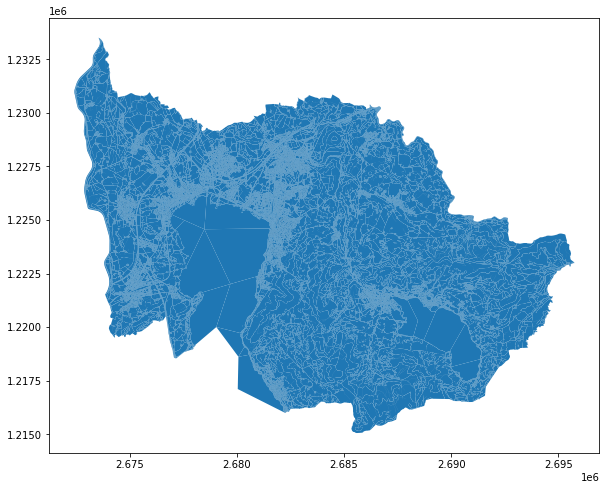

In [5]:
zug = gpd.read_file(src, layer='lcsf')
# zug.plot(figsize=(16,8))

In [6]:
minX, minY, maxX, maxY = zug.total_bounds

In [7]:
zug.crs

<Derived Projected CRS: EPSG:2056>
Name: CH1903+ / LV95
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Liechtenstein; Switzerland.
- bounds: (5.96, 45.82, 10.49, 47.81)
Coordinate Operation:
- name: Swiss Oblique Mercator 1995
- method: Hotine Oblique Mercator (variant B)
Datum: CH1903+
- Ellipsoid: Bessel 1841
- Prime Meridian: Greenwich

In [8]:
maxX-minX

23331.305999999866

In [9]:
maxY-minY

18445.216999999946

# Manipulation and Export

In [10]:
colMap = {'edificio':'k', 
          'altro_rivestimento_duro':'w', 
          'giardino':'dimgray', 
          'marciapiede':'w',
          'campo_prato_pascolo':'dimgray',
          'altro_humus':'dimgray',
          'vigna':'dimgray',
          'ferrovia': 'dimgray',
          'bosco_fitto': 'dimgray', 
          'bacino_idrico': 'dimgray', 
          'spartitraffico':'w', 
          'corso_acqua':'dimgray',
          'specchio_acqua':'dimgray', 
          'strada_sentiero':'w',
          'pietraia_sabbia':'dimgray',
          'torbiera': 'dimgray',
          'altra_coltura_intensiva': 'dimgray',
          'altro_bosco': 'dimgray',
          'cava_di_ghiaia_discarica': 'dimgray',
          'pascolo_boscato_fitto': 'dimgray',
          'canneti': 'dimgray',
          'roccia': 'dimgray',
          'bacino_idrico': 'dimgray',
          'specchio_acqua': 'dimgray'
         }

In [25]:
def cutAndprint(geometries, step, path):
    minX, minY, maxX, maxY = geometries.total_bounds
    repsX, repsY= int((maxX-minX)/step), int((maxY-minY)/step)
    for x in range(repsX):#range(1):
        for y in range(repsY): #range(1):
            box = gpd.GeoSeries([Polygon([(minX + (x+0) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+0) * step),
                                         (minX + (x+1) * step, minY + (y+1) * step),
                                         (minX + (x+0) * step, minY + (y+1) * step)])
                                      ],)
            boxGDF = gpd.GeoDataFrame.from_features(box)
            boxGDF = boxGDF.set_crs('EPSG:2056')
            res = gpd.sjoin(geometries, boxGDF, how='inner', predicate='intersects')
            res['col']= res['Genere'].map(colMap)
            nObjs = res.shape[0]
            nBld = res[res.Genere == 'edificio'].shape[0]
            
            # PLOT
            resolution = 72 # in dpi
            plt.ioff() # turns off interactive plotting
            if (nObjs > 100) and (nBld>10): # only interesting plots
                filename = path + 'CadastralX' + str(int(minX+x*step)) + 'Y' + str(int(minY+y*step)) + 'S' + str(step) + ".png" 
                #larger size, to use the crop in the dataloader
                res_multiplier = 20
                fig, ax = plt.subplots(figsize=(res_multiplier*64/resolution,res_multiplier*64/resolution), dpi=resolution, frameon=False)
                ax = plt.axes([0,0,1,1], frameon=False)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)
                plt.autoscale(tight=True)
                mpl.rcParams['savefig.pad_inches'] = 0
                
                ax.set_xlim(boxGDF.bounds['minx'].item(), boxGDF.bounds['maxx'].item())
                ax.set_ylim(boxGDF.bounds['miny'].item(), boxGDF.bounds['maxy'].item())
                res.plot(ax=ax, color=res['col'])
                plt.savefig(filename)
                plt.close(fig)
                # EXPORT CSV INSTEAD OF IMAGE WITH XCOORD, YCOORD, REWARD
            
            # print("Geometries in raster: {} | Box: X({}, {}), Y({}, {})".format(res.shape[0],
            #      box.total_bounds[0], box.total_bounds[2], 
            #      box.total_bounds[1], box.total_bounds[3]))

In [ ]:
%%time
path = '../data/cadastralExport/'
cutAndprint(zug, 250, path)

In [ ]:
%%time
cutAndprint(zubeagge, 250, path)

# Open and convert data to environment